# ml-mipt advanced course
# Seminar 15: Variational autoencoders

This notebook is inspired by and based on [this demonstration of VAE in keras](https://github.com/msurtsukov/ae_vae_gan)

In [1]:
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torchvision
import tqdm
from matplotlib import cm
from matplotlib.animation import FuncAnimation
from scipy.stats import norm
from torch import nn
from torchsummary import summary
from torchvision import transforms

In [2]:
sns.set()

In [3]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

In [4]:
# It's dangerous to walk alone. Take these ;)


class Rescale(object):
    def __call__(self, image):
        image = image - image.min()
        image = image / image.max()

        return image


class RestoreShape(nn.Module):
    def __init__(self, initial_shape):
        super().__init__()
        self.initial_shape = initial_shape

    def forward(self, x):
        return x.view([-1] + list(self.initial_shape))

Also keep in mind [`torch.nn.Flatten` module](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html)

## Prepare dataset

In [5]:
mnist_transformations = transforms.Compose(
    [
        transforms.ToTensor(),
        Rescale(),
        # transforms.Normalize((0.1307,), (0.3081,)),
    ]
)

In [6]:
curr_dir = Path().resolve()
datasets_dir = curr_dir.parent / "datasets"

DATA_ROOT = datasets_dir if datasets_dir.exists() else curr_dir
BATCH_SIZE = 256
SHUFFLE_DATASET = True
NUM_DATALOADER_WORKERS = 1

In [7]:
mnist_train = torchvision.datasets.MNIST(
    DATA_ROOT, train=True, download=True, transform=mnist_transformations
)

train_loader = torch.utils.data.DataLoader(
    mnist_train,
    BATCH_SIZE,
    SHUFFLE_DATASET,
    num_workers=NUM_DATALOADER_WORKERS,
)

In [8]:
mnist_test = torchvision.datasets.MNIST(DATA_ROOT, train=False, transform=mnist_transformations)

test_loader = torch.utils.data.DataLoader(
    mnist_test,
    BATCH_SIZE,
    False,
    num_workers=NUM_DATALOADER_WORKERS,
)

## Define autoencoder

In [9]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self, intermediate_dims, latent_dim, input_shape):
        super().__init__()
        self.register_buffer("_initial_mu", torch.zeros((latent_dim)))
        self.register_buffer("_initial_sigma", torch.ones((latent_dim)))

        self.latent_distribution = torch.distributions.normal.Normal(
            loc=self._initial_mu, scale=self._initial_sigma
        )
        input_dim = np.prod(input_shape)
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, intermediate_dims[0]),
            nn.ReLU(),
            nn.BatchNorm1d(intermediate_dims[0]),
            nn.Dropout(0.3),
            nn.Linear(intermediate_dims[0], intermediate_dims[1]),
            nn.ReLU(),
            nn.BatchNorm1d(intermediate_dims[1]),
            nn.Dropout(0.3),
        )

        # YOUR CODE HERE: define mu and sigma
        self.mu_repr = None
        self.log_sigma_repr = None

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, intermediate_dims[1]),
            nn.LeakyReLU(),
            nn.BatchNorm1d(intermediate_dims[1]),
            nn.Dropout(0.3),
            nn.Linear(intermediate_dims[1], intermediate_dims[0]),
            nn.LeakyReLU(),
            nn.BatchNorm1d(intermediate_dims[0]),
            nn.Dropout(0.3),
            nn.Linear(intermediate_dims[0], input_dim),
            nn.Sigmoid(),
            RestoreShape(input_shape),
        )

    def _encode(self, x):
        latent_repr = self.encoder(x)
        mu_values = self.mu_repr(latent_repr)
        log_sigma_values = self.log_sigma_repr(latent_repr)
        return mu_values, log_sigma_values, latent_repr

    def _reparametrize(self, sample, mu_values, log_sigma_values):
        # YOUR CODE HERE: reparametrize sample
        latent_sample = None
        return latent_sample

    def forward(self, x, raw_sample=None):
        mu_values, log_sigma_values, latent_repr = self._encode(x)

        if raw_sample is None:
            raw_sample = torch.randn_like(mu_values)

        latent_sample = self._reparametrize(raw_sample, mu_values, log_sigma_values)

        reconstructed_repr = self.decoder(latent_sample)

        return reconstructed_repr, latent_sample, mu_values, log_sigma_values

## Train model

In [12]:
def plot_digits(*args):
    args = [x.squeeze() for x in args]
    n = min([x.shape[0] for x in args])

    fig = plt.figure(figsize=(2 * n, 2 * len(args)))
    for j in range(n):
        for i in range(len(args)):
            ax = plt.subplot(len(args), n, i * n + j + 1)
            plt.imshow(args[i][j])
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

    # plt.show()
    return fig

In [13]:
example_batch = next(iter(train_loader))
example_batch = [x.to(device) for x in example_batch]
example_x = example_batch[0][0]

model = VariationalAutoEncoder([256, 128], 2, example_x.shape).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_func = torch.nn.modules.loss.BCELoss()

sample = example_batch[0][:15].to(device)
reconstructed_repr, latent_sample, mu_values, log_sigma_values = model(sample)

summary(model, example_x.shape)

In [14]:
# YOUR CODE HERE: define kl_loss
kl_loss = None
kl_loss

In [15]:
test_batch = next(iter(test_loader))

In [16]:
def get_test_predictions(model, test_loader):
    model.eval()

    reconstructed_repr_list = []
    latent_samples_list = []
    mu_values_list = []
    log_sigma_values_list = []

    for test_batch in tqdm.tqdm_notebook(test_loader, leave=False):
        out = model(test_batch[0].to(device))
        reconstructed_repr, latent_sample, mu_values, log_sigma_values = [
            x.detach().cpu() for x in out
        ]
        reconstructed_repr_list.append(reconstructed_repr)
        latent_samples_list.append(latent_sample)
        mu_values_list.append(mu_values)
        log_sigma_values_list.append(log_sigma_values)

    return [
        torch.cat(item, dim=0)
        for item in (
            reconstructed_repr_list,
            latent_samples_list,
            mu_values_list,
            log_sigma_values_list,
        )
    ]

In [ ]:
reconstructed_repr, latent_sample, mu_values, log_sigma_values = get_test_predictions(
    model, test_loader
)

In [17]:
n = 15  # to generate image with 15x15 examples
digit_size = 28
latent_dim = 2


grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))


def draw_manifold(model, show=True):
    figure = np.zeros((digit_size * n, digit_size * n))
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = np.zeros((1, latent_dim))
            z_sample[:, :2] = np.array([[xi, yi]])

            z_torch = torch.from_numpy(z_sample).type(torch.FloatTensor).to(device)

            x_decoded = model.decoder(z_torch).detach().cpu().numpy()
            digit = x_decoded[0].squeeze()
            figure[
                i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size
            ] = digit
    if show:
        plt.figure(figsize=(15, 15))
        plt.imshow(figure, cmap="Greys_r")
        # plt.grid(None)
        ax = plt.gca()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.show()
    return figure

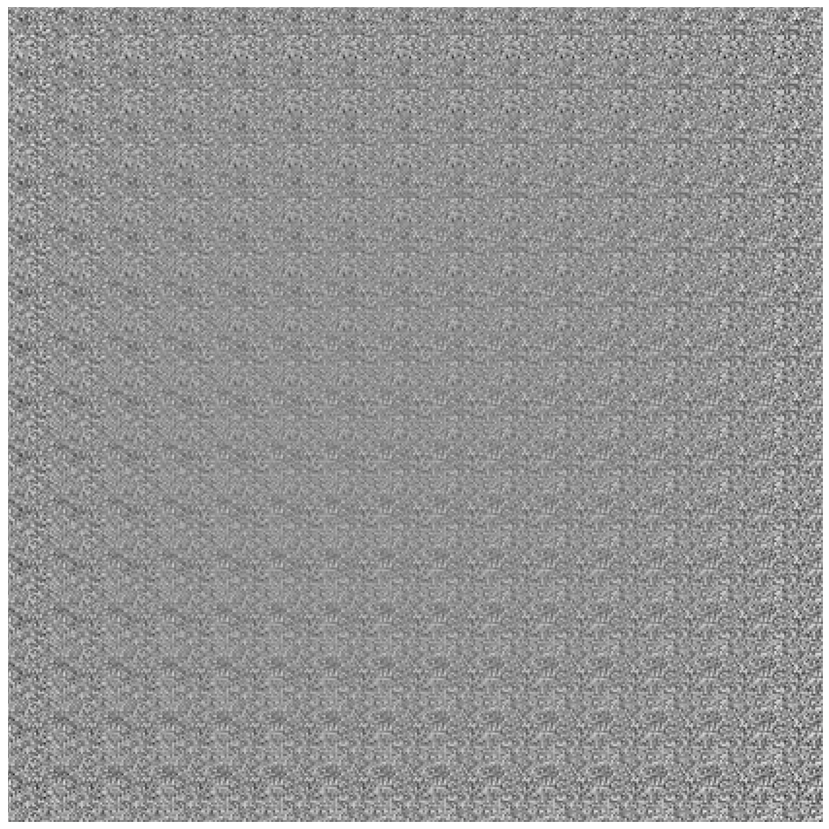

In [18]:
model.eval()
_img = draw_manifold(model, True)

In [19]:
def on_epoch_end(epoch):
    # Saving manifold and z distribution to build plots and animation afterwards
    figure = draw_manifold(model, show=False)
    reconstructed_repr, latent_sample, mu_values, log_sigma_values = get_test_predictions(
        model, test_loader
    )
    return figure, reconstructed_repr, latent_sample, mu_values, log_sigma_values

In [20]:
def train(num_epochs):
    epochs, figs, latent_distrs = [], [], []
    for epoch_num in tqdm.tnrange(num_epochs):
        model.train()
        loss_accumulator = 0.0
        bce_acc = 0.0
        kl_acc = 0.0
        for batch_x, batch_label in tqdm.tqdm_notebook(train_loader, leave=False):
            batch_x = batch_x.to(device)
            predictions, latent, mu_values, log_sigma_values = model(batch_x)

            # YOUR CODE HERE: same kl_loss as above
            kl_loss = None
            bce_loss = 28 * 28 * loss_func(predictions, batch_x)
            loss = (bce_loss + kl_loss) / 2.0 / 28.0 / 28.0
            loss.backward()
            opt.step()
            opt.zero_grad()

            loss_accumulator += loss / (len(train_loader.dataset))
            bce_acc += bce_loss / (len(train_loader.dataset))
            kl_acc += kl_loss / (len(train_loader.dataset))

        if epoch_num % 5 == 0:
            print(
                "Epoch num: {}\nTraining loss={:.4f}, KL divergence={:.4f}, BCE Loss={:.4f}".format(
                    epoch_num, loss_accumulator, kl_acc, bce_acc
                )
            )
            model.eval()
            (
                figure,
                reconstructed_repr_test,
                latent_sample_test,
                mu_values_test,
                log_sigma_values_test,
            ) = on_epoch_end(epoch_num)
            epochs.append(epoch_num)
            figs.append(figure)
            latent_distrs.append((mu_values_test, log_sigma_values_test))
    return epochs, figs, latent_distrs

In [ ]:
epochs, figs, latent_distrs = train(50)

In [ ]:
test_labels = []
for b in test_loader:
    test_labels.append(b[1])
test_labels = torch.cat(test_labels, dim=0).numpy()

In [ ]:
Path("./my_figs").mkdir(exist_ok=True)


def make_2d_figs_gif(figs, epochs, fname, fig):
    norm = matplotlib.colors.Normalize(vmin=0, vmax=1, clip=False)
    im = plt.imshow(np.zeros((28, 28)), cmap="Greys_r", norm=norm)
    plt.grid(None)
    plt.title("Epoch: " + str(epochs[0]))

    def update(i):
        im.set_array(figs[i])
        im.axes.set_title("Epoch: " + str(epochs[i]))
        im.axes.get_xaxis().set_visible(False)
        im.axes.get_yaxis().set_visible(False)
        return im

    anim = FuncAnimation(fig, update, frames=range(len(figs)), interval=100)
    anim.save(fname, dpi=80, writer="imagemagick")


def make_2d_scatter_gif(zs, epochs, c, fname, fig):
    im = plt.scatter(zs[0][:, 0], zs[0][:, 1], c=c, cmap=cm.coolwarm)  # noqa: F841
    plt.colorbar()
    plt.title("Epoch: " + str(epochs[0]))

    def update(i):
        fig.clear()
        im = plt.scatter(zs[i][:, 0], zs[i][:, 1], c=c, cmap=cm.coolwarm)
        im.axes.set_title("Epoch: " + str(epochs[i]))
        im.axes.set_xlim(-5, 5)
        im.axes.set_ylim(-5, 5)
        return im

    anim = FuncAnimation(fig, update, frames=range(len(zs)), interval=150)
    anim.save(fname, dpi=80, writer="imagemagick")


make_2d_figs_gif(figs, epochs, "./my_figs/manifold2.gif", plt.figure(figsize=(10, 10)))
make_2d_scatter_gif(
    [x[0].numpy() for x in latent_distrs],
    epochs,
    test_labels,
    "./my_figs/z_distr2.gif",
    plt.figure(figsize=(10, 10)),
)

You can find your brand gifs in `./my_figs/` directory ;)

Your home assignment will be to implement conditional VAE (and make in convolutional) and optionally implement GAN. 